In [1]:
%run "..\..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

35420


In [2]:
library_master_folder = r'I:\MERFISH_LibraryDesign'

In [3]:
# Define all the input files you need in this script
transcripts_fasta_file = os.path.join(library_master_folder, r'MERFISH_Examples2\transcripts.fasta')
fpkm_tracking_file = os.path.join(library_master_folder, r'MERFISH_Examples2\isoforms.fpkm_tracking')
readout_fasta_file = os.path.join(library_master_folder, r'MERFISH_Examples2\readouts.fasta')
ncRNA_file = os.path.join(library_master_folder, r'MERFISH_Examples2\Homo_sapiens.GRCh38.ncrna.fa')
# Define the output files
library_folder = os.path.join(library_master_folder, 'hc9orf72')
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')

In [4]:
transcripts_fasta_file

'I:\\MERFISH_LibraryDesign\\MERFISH_Examples2\\transcripts.fasta'

In [5]:
# Import the modules
import os
from IPython.display import display
import numpy as np
import pandas as pd

import MERFISH_probe_design.MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.MERFISH_probe_design.probe_design import plot

In [6]:
%%time
# Load the transcriptome as a pandas data frame
transcriptome = fio.load_transcriptome(transcripts_fasta_file, fpkm_tracking_file)

# Make sure that the transcriptome data frame has the standard column names.
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name and FPKM.
# Also remove the non-standard columns for clarity.
transcriptome = qc.check_and_standardize_transcriptome(transcriptome, remove_non_standard_columns=True)

# This FPKM data is not for our cell type of interest. So set the FPKMs to be all 1.
transcriptome['FPKM'] = 1

Loaded 198798 transcripts.
Loaded FPKMs for 215942 transcripts of 66008 genes.
Kept 198664 transcripts of 60655 genes after merging.
Wall time: 5.34 s


# Alternatively directly use sequences from Shawn

In [7]:
# seq
sequence_folder = r'I:\MERFISH_LibraryDesign\hc9orf72\sequences'
# rewrite gene_df according to Shawn's input
gene_dicts = []
for _fl in os.listdir(sequence_folder):
    if '.txt' in _fl:
        _name = _fl.split('.txt')[0].split('C9orf72_')[1]
        _seq = str(np.loadtxt(os.path.join(sequence_folder, _fl), dtype=str))
    # append
    gene_dicts.append(
        {'transcript_id':_name, 
         'sequence':_seq, 
         'gene_id':'ENSG00000147894.14', 
         'gene_short_name':'C9orf72_manual',
         'FPKM':1,
        }
    )

In [8]:
gene_df = pd.DataFrame(gene_dicts)
gene_df

,transcript_id,sequence,gene_id,gene_short_name,FPKM
0,Variant-1_lack of Exon1a,atatctccggagcatttggataatgtgacagttggaatgcagtgat...,ENSG00000147894.14,C9orf72_manual,1
1,Variant-2,ggtggcgagtggatatctccggagcatttagataatgtgacagttg...,ENSG00000147894.14,C9orf72_manual,1
2,Variant-3,aggaaagagaggtgcgtcaaacagcgacaagttccgcccacgtaaa...,ENSG00000147894.14,C9orf72_manual,1


### append to transcriptome

In [9]:
transcriptome = transcriptome.loc[transcriptome['gene_short_name'] != 'C9orf72']

In [10]:
transcriptome = transcriptome.append(gene_df)

C:\Users\puzheng\AppData\Local\Temp\2\ipykernel_35420\661858605.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcriptome = transcriptome.append(gene_df)


In [32]:
sel_isoform_names = ['Variant-1_lack of Exon1a','Variant-2','Variant-3']

## generate count table

In [22]:
# Initialize the off-target counting tables
# OTTable for rRNA/tRNAs
ncRNAs =  fio.load_fasta_into_df(ncRNA_file)
ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 587 rRNAs/tRNAs from 37612 non-coding RNAs.


In [23]:
# OTTables for the genes we target
#gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_isoform_names, 'transcript_id', 17)
gene_ottable_dict = ot.get_gene_OTTables(transcriptome, ['C9orf72_manual'], 'gene_short_name', 17)

Generate OTTable for gene C9orf72_manual.
Construct a OTTable using 3/3 transcripts with FPKM > 0.


In [24]:
# OTTable for the transcriptome.
ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 198661/198661 transcripts with FPKM > 0.
Processed 1000/198661 sequences.
Processed 2000/198661 sequences.
Processed 3000/198661 sequences.
Processed 4000/198661 sequences.
Processed 5000/198661 sequences.
Processed 6000/198661 sequences.
Processed 7000/198661 sequences.
Processed 8000/198661 sequences.
Processed 9000/198661 sequences.
Processed 10000/198661 sequences.
Processed 11000/198661 sequences.
Processed 12000/198661 sequences.
Processed 13000/198661 sequences.
Processed 14000/198661 sequences.
Processed 15000/198661 sequences.
Processed 16000/198661 sequences.
Processed 17000/198661 sequences.
Processed 18000/198661 sequences.
Processed 19000/198661 sequences.
Processed 20000/198661 sequences.
Processed 21000/198661 sequences.
Processed 22000/198661 sequences.
Processed 23000/198661 sequences.
Processed 24000/198661 sequences.
Processed 25000/198661 sequences.
Processed 26000/198661 sequences.
Processed 27000/198661 sequences.
Processed 28000/198661 s

## init probe dict

In [321]:
final_probe_dict = {}
final_probe_dict['C9orf72_manual'] = {}

# Part 1: non-specific probes

Found 3 transcripts for 1 target genes.
Gene	Transcript	N_probes
C9orf72_manual
	Variant-1_lack of Exon1a	1795
	Variant-2	2785
	Variant-3	3287
Gene	Transcript	N_probes
C9orf72_manual
	Variant-1_lack of Exon1a	1795
C9orf72_manual
	Variant-1_lack of Exon1a: 401 / 1795 probes passed the filter 40 < target_GC <  70.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


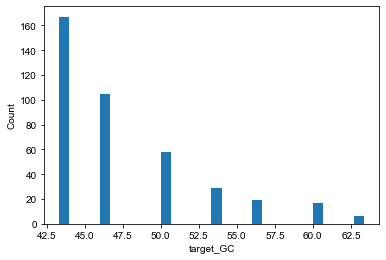

C9orf72_manual
	Variant-1_lack of Exon1a: 375 / 401 probes passed the filter 50 < target_Tm <  inf.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


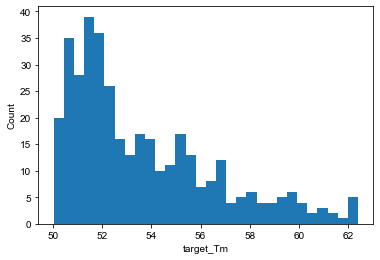

Calculate OTs for 0/1 genes.
C9orf72_manual
	Variant-1_lack of Exon1a: 375 / 375 probes passed the filter -inf < target_OT_rtRNA <  0.5.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


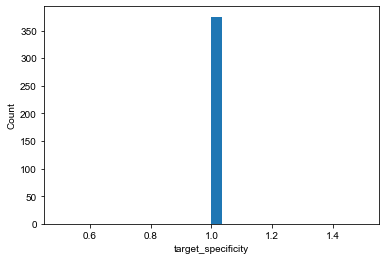

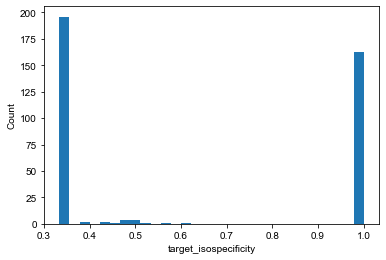

C9orf72_manual
	Variant-1_lack of Exon1a: 375 / 375 probes passed the filter 0.99 < target_specificity <  inf.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


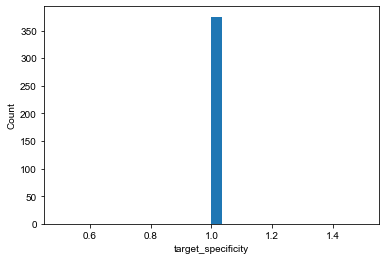

C9orf72_manual
	Variant-1_lack of Exon1a: 195 / 375 probes passed the filter 0.0 < target_isospecificity <  0.34.


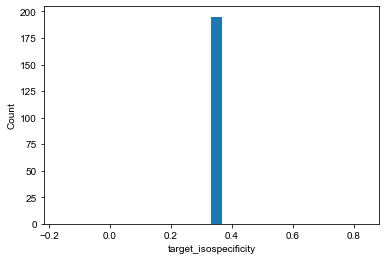

             name                        id barcode_str
0  C9orf72_manual  Variant-1_lack of Exon1a    11000000


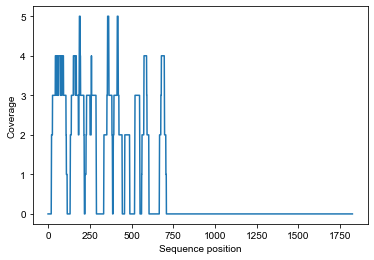

Calculate OTs for 0/1 genes.


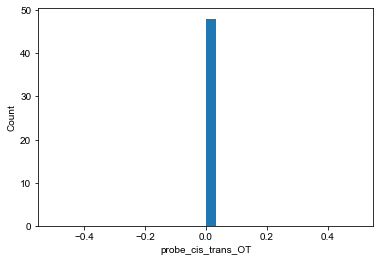

In [315]:
probe_dict = p_d.init_probe_dict(['C9orf72_manual'], 
                                 transcriptome, 'gene_short_name', K=30)
p_d.print_probe_dict(probe_dict)

# Select the transcripts that we want to target
# The target transcripts are already defined in the codebook
probe_dict = p_d.select_transcripts_by_ids(probe_dict, transcript_ids=['Variant-1_lack of Exon1a', ])
p_d.print_probe_dict(probe_dict) # We excluded all the transcripts that are not our direct targets

%matplotlib inline

# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
#plot.plot_hist(probe_dict, column_key='target_GC')
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC')

# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
#plot.plot_hist(probe_dict, column_key='target_Tm')
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50)
plot.plot_hist(probe_dict, column_key='target_Tm')

# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')


# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_isospecificity', lower_bound=0., upper_bound=0.34)
plot.plot_hist(probe_dict, 'target_isospecificity')

# add readouts
# Generate a codebook table for the target transcript
# Choose one of the full length protein coding transcript as the target

merfish_readout_df = pd.read_excel(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts\MERFISH_readouts\readout_table_v2_corrected.xls')

readout_seqs = pd.DataFrame()
readout_seqs['id'] = merfish_readout_df['Probe name']
readout_seqs['sequence'] = merfish_readout_df['Sequence']
readout_seqs['on-bit'] = merfish_readout_df.index
#print(readout_seqs)
barcode_table = pd.DataFrame({'name':['C9orf72_manual',], 
                              'id':['Variant-1_lack of Exon1a'], 
                              'barcode_str':['11000000']})
print(barcode_table)

# Add the readout sequences. Here we randomly add 2 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
rs.add_readout_seqs_to_probes_random(probe_dict, readout_seqs, barcode_table, 2, 
                                     spacer='T', gene_id_key='name', each_probe_1_on_bit=True)

# Select probes by a stochastic greedy algorithms that optimizes the on-bit coverage
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=48, N_on_bits=2)
#ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=12, N_on_bits=2)

# Let's plot the probe coverage of an example transcript
seq_len = len(transcriptome[transcriptome['transcript_id'] == 'Variant-1_lack of Exon1a'].iloc[0]['sequence'])
plot.plot_sequence_coverage(probe_dict['C9orf72_manual']['Variant-1_lack of Exon1a'], seq_len)

# Filter out the probes that self complement or complement with other probes.

# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(probe_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(probe_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(probe_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(probe_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(probe_dict, 'probe_cis_trans_OT')


In [329]:
# manually save
_pb_df = probe_dict['C9orf72_manual']['Variant-1_lack of Exon1a'].copy()
_pb_df['transcript_id'] = '3variants_shared'
# append
final_probe_dict['C9orf72_manual']['3variants_shared'] = _pb_df
_pb_df

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,probe_cis_trans_OT
63,C9orf72_manual,3variants_shared,63,cgccatctccagctgttgccaagacagaga,56.666667,57.014626,0,1.0,0.333333,RS0015::RS0015,10000000,ATCCTCCTTCAATACATCCCTcgccatctccagctgttgccaagac...,0
185,C9orf72_manual,3variants_shared,185,aagacagaacaggtacttctcagtgatgga,43.333333,50.659426,0,1.0,0.333333,RS0083::RS0083,01000000,ACACTACCACCATTTCCTATTaagacagaacaggtacttctcagtg...,0
563,C9orf72_manual,3variants_shared,563,ccaatgcttactggagaagtgattcctgta,43.333333,51.024936,0,1.0,0.333333,RS0015::RS0015,10000000,ATCCTCCTTCAATACATCCCTccaatgcttactggagaagtgattc...,0
353,C9orf72_manual,3variants_shared,353,aatggggatcgcagcacatatggactatca,46.666667,54.445348,0,1.0,0.333333,RS0083::RS0083,01000000,ACACTACCACCATTTCCTATTaatggggatcgcagcacatatggac...,0
27,C9orf72_manual,3variants_shared,27,acagttggaatgcagtgatgtcgactcttt,43.333333,51.311103,0,1.0,0.333333,RS0015::RS0015,10000000,ATCCTCCTTCAATACATCCCTacagttggaatgcagtgatgtcgac...,0
521,C9orf72_manual,3variants_shared,521,gaaggcacagagagaatggaagatcagggt,50.000000,53.575591,0,1.0,0.333333,RS0083::RS0083,01000000,ACACTACCACCATTTCCTATTgaaggcacagagagaatggaagatc...,0
676,C9orf72_manual,3variants_shared,676,tggtgacagctgtcatgaaggctttcttct,46.666667,53.106371,0,1.0,0.333333,RS0015::RS0015,10000000,ATCCTCCTTCAATACATCCCTtggtgacagctgtcatgaaggcttt...,0
460,C9orf72_manual,3variants_shared,460,ccggaaaggaagaatatggatgcataagga,43.333333,52.157853,0,1.0,0.333333,RS0083::RS0083,01000000,ACACTACCACCATTTCCTATTccggaaaggaagaatatggatgcat...,0
395,C9orf72_manual,3variants_shared,395,cagacagaacttagtttctacctcccactt,43.333333,50.513994,0,1.0,0.333333,RS0083::RS0083,01000000,ACACTACCACCATTTCCTATTcagacagaacttagtttctacctcc...,0
152,C9orf72_manual,3variants_shared,152,cttggtcctagagtaaggcacatttgggct,50.000000,55.396659,0,1.0,0.333333,RS0015::RS0015,10000000,ATCCTCCTTCAATACATCCCTcttggtcctagagtaaggcacattt...,0


# Part 2: 2&3 specific probes

Found 3 transcripts for 1 target genes.
Gene	Transcript	N_probes
C9orf72_manual
	Variant-1_lack of Exon1a	1795
	Variant-2	2785
	Variant-3	3287
Gene	Transcript	N_probes
C9orf72_manual
	Variant-2	2785
C9orf72_manual
	Variant-2: 922 / 2785 probes passed the filter 40 < target_GC <  70.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


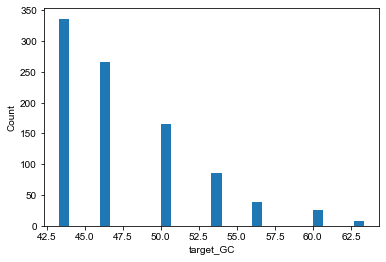

C9orf72_manual
	Variant-2: 868 / 922 probes passed the filter 50 < target_Tm <  inf.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


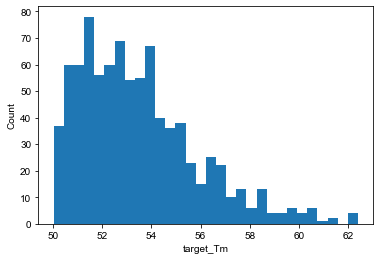

Calculate OTs for 0/1 genes.
C9orf72_manual
	Variant-2: 868 / 868 probes passed the filter -inf < target_OT_rtRNA <  0.5.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


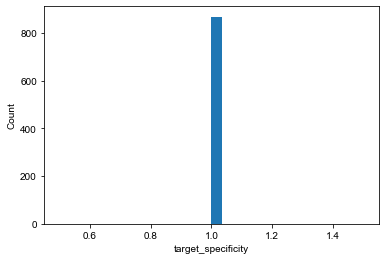

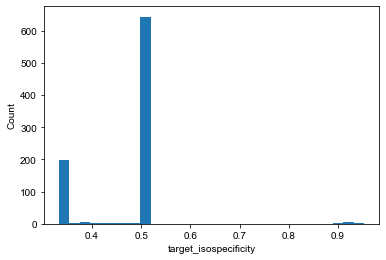

C9orf72_manual
	Variant-2: 868 / 868 probes passed the filter 0.99 < target_specificity <  inf.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


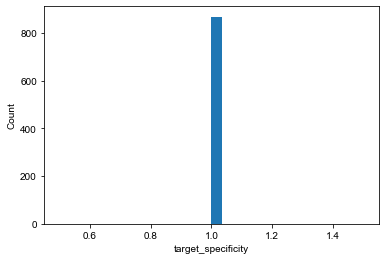

C9orf72_manual
	Variant-2: 643 / 868 probes passed the filter 0.49999 < target_isospecificity <  0.50001.


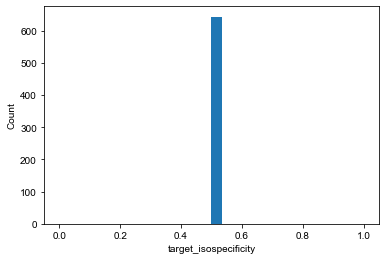

             name         id barcode_str
0  C9orf72_manual  Variant-2    00110000


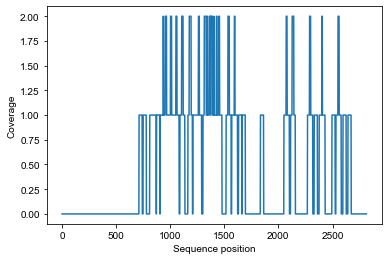

Calculate OTs for 0/1 genes.


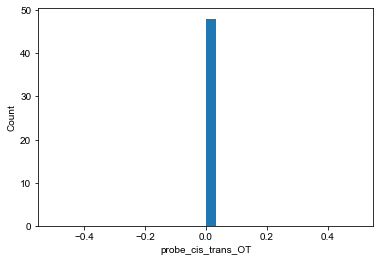

In [330]:
probe_dict = p_d.init_probe_dict(['C9orf72_manual'], 
                                 transcriptome, 'gene_short_name', K=30)
p_d.print_probe_dict(probe_dict)

# Select the transcripts that we want to target
# The target transcripts are already defined in the codebook
probe_dict = p_d.select_transcripts_by_ids(probe_dict, transcript_ids=['Variant-2', ])
p_d.print_probe_dict(probe_dict) # We excluded all the transcripts that are not our direct targets

%matplotlib inline

# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
#plot.plot_hist(probe_dict, column_key='target_GC')
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC')

# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
#plot.plot_hist(probe_dict, column_key='target_Tm')
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50)
plot.plot_hist(probe_dict, column_key='target_Tm')

# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')


# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_isospecificity', lower_bound=0.49999, upper_bound=0.50001)
plot.plot_hist(probe_dict, 'target_isospecificity')

# add readouts
# Generate a codebook table for the target transcript
# Choose one of the full length protein coding transcript as the target

merfish_readout_df = pd.read_excel(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts\MERFISH_readouts\readout_table_v2_corrected.xls')

readout_seqs = pd.DataFrame()
readout_seqs['id'] = merfish_readout_df['Probe name']
readout_seqs['sequence'] = merfish_readout_df['Sequence']
readout_seqs['on-bit'] = merfish_readout_df.index
#print(readout_seqs)
barcode_table = pd.DataFrame({'name':['C9orf72_manual',], 
                              'id':['Variant-2'], 
                              'barcode_str':['00110000']})
print(barcode_table)

# Add the readout sequences. Here we randomly add 2 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
rs.add_readout_seqs_to_probes_random(probe_dict, readout_seqs, barcode_table, 2, 
                                     spacer='T', gene_id_key='name', each_probe_1_on_bit=True)

# Select probes by a stochastic greedy algorithms that optimizes the on-bit coverage
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=48, N_on_bits=2)
#ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=12, N_on_bits=2)

# Let's plot the probe coverage of an example transcript
seq_len = len(transcriptome[transcriptome['transcript_id'] == 'Variant-2'].iloc[0]['sequence'])
plot.plot_sequence_coverage(probe_dict['C9orf72_manual']['Variant-2'], seq_len)

# Filter out the probes that self complement or complement with other probes.

# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(probe_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(probe_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(probe_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(probe_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(probe_dict, 'probe_cis_trans_OT')


In [332]:
# manually save
_pb_df = probe_dict['C9orf72_manual']['Variant-2'].copy()
_pb_df['transcript_id'] = '2_3_shared'
# append
final_probe_dict['C9orf72_manual']['2_3_shared'] = _pb_df
_pb_df

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,probe_cis_trans_OT
1314,C9orf72_manual,2_3_shared,1314,cgcagaagggaaaaaagccctttaaatctc,43.333333,51.566500,0,1.0,0.5,RS0109::RS0109,00010000,ACCCTCTAACTTCCATCACATcgcagaagggaaaaaagccctttaa...,0
1533,C9orf72_manual,2_3_shared,1533,atcatgatcgctggtaaagtagctcagtgg,46.666667,52.239448,0,1.0,0.5,RS0095::RS0095,00100000,ACTCCACTACTACTCACTCTTatcatgatcgctggtaaagtagctc...,0
2596,C9orf72_manual,2_3_shared,2596,ctgttttcctaggtgctactttggcagagc,50.000000,53.794743,0,1.0,0.5,RS0109::RS0109,00010000,ACCCTCTAACTTCCATCACATctgttttcctaggtgctactttggc...,0
711,C9orf72_manual,2_3_shared,711,ttcttctcaatgccatcagctcacacttgc,46.666667,52.158438,0,1.0,0.5,RS0095::RS0095,00100000,ACTCCACTACTACTCACTCTTttcttctcaatgccatcagctcaca...,0
1631,C9orf72_manual,2_3_shared,1631,cactacagttctcacaagagcctgtgaggg,53.333333,53.912511,0,1.0,0.5,RS0095::RS0095,00100000,ACTCCACTACTACTCACTCTTcactacagttctcacaagagcctgt...,0
2550,C9orf72_manual,2_3_shared,2550,cctgcaataggctataaggaatagcaggag,46.666667,52.425968,0,1.0,0.5,RS0109::RS0109,00010000,ACCCTCTAACTTCCATCACATcctgcaataggctataaggaatagc...,0
1089,C9orf72_manual,2_3_shared,1089,aagaagacatggctcaggatacgatcatct,43.333333,50.866451,0,1.0,0.5,RS0109::RS0109,00010000,ACCCTCTAACTTCCATCACATaagaagacatggctcaggatacgat...,0
1402,C9orf72_manual,2_3_shared,1402,ggctctggctgagaaaattaaaccaggcct,50.000000,55.767934,0,1.0,0.5,RS0095::RS0095,00100000,ACTCCACTACTACTCACTCTTggctctggctgagaaaattaaacca...,0
2287,C9orf72_manual,2_3_shared,2287,tgcacctcctgtgccttttttctccttaga,46.666667,54.387954,0,1.0,0.5,RS0095::RS0095,00100000,ACTCCACTACTACTCACTCTTtgcacctcctgtgccttttttctcc...,0
1052,C9orf72_manual,2_3_shared,1052,agatccgagctgacagccttctggagagcc,60.000000,58.101578,0,1.0,0.5,RS0109::RS0109,00010000,ACCCTCTAACTTCCATCACATagatccgagctgacagccttctgga...,0


# Part 3: Specific varient 1

Found 3 transcripts for 1 target genes.
Gene	Transcript	N_probes
C9orf72_manual
	Variant-1_lack of Exon1a	1795
	Variant-2	2785
	Variant-3	3287
Gene	Transcript	N_probes
C9orf72_manual
	Variant-1_lack of Exon1a	1795
C9orf72_manual
	Variant-1_lack of Exon1a: 401 / 1795 probes passed the filter 40 < target_GC <  70.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


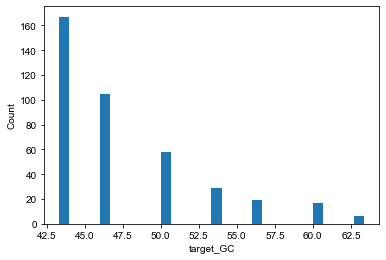

C9orf72_manual
	Variant-1_lack of Exon1a: 375 / 401 probes passed the filter 50 < target_Tm <  inf.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


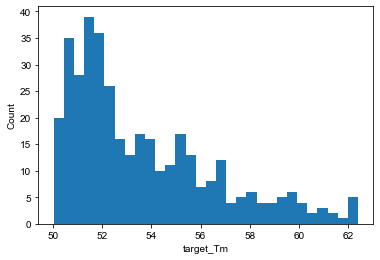

E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


Calculate OTs for 0/1 genes.
C9orf72_manual
	Variant-1_lack of Exon1a: 375 / 375 probes passed the filter -inf < target_OT_rtRNA <  0.5.


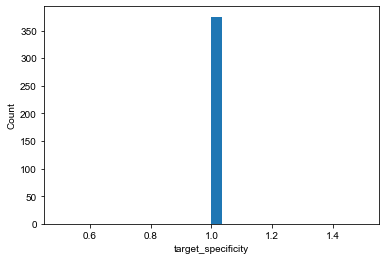

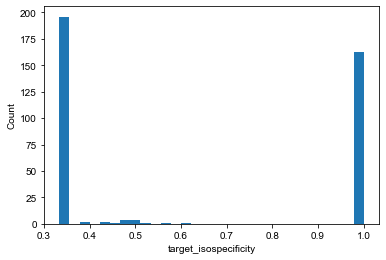

C9orf72_manual
	Variant-1_lack of Exon1a: 375 / 375 probes passed the filter 0.99 < target_specificity <  inf.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


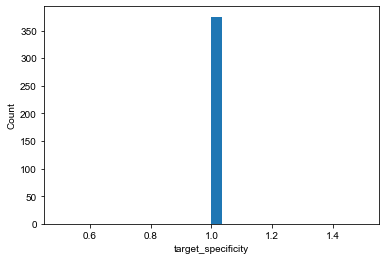

C9orf72_manual
	Variant-1_lack of Exon1a: 163 / 375 probes passed the filter 0.99 < target_isospecificity <  inf.


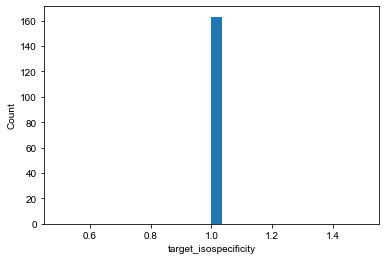

             name                        id barcode_str
0  C9orf72_manual  Variant-1_lack of Exon1a    00001100


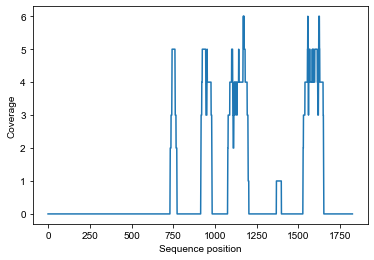

Calculate OTs for 0/1 genes.


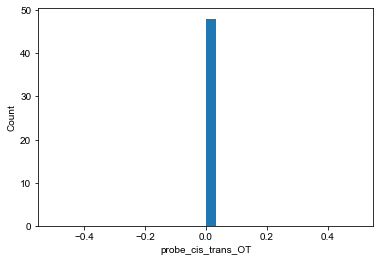

In [361]:
probe_dict = p_d.init_probe_dict(['C9orf72_manual'], 
                                 transcriptome, 'gene_short_name', K=30)
p_d.print_probe_dict(probe_dict)

# Select the transcripts that we want to target
# The target transcripts are already defined in the codebook
probe_dict = p_d.select_transcripts_by_ids(probe_dict, transcript_ids=['Variant-1_lack of Exon1a'])
p_d.print_probe_dict(probe_dict) # We excluded all the transcripts that are not our direct targets

%matplotlib inline

# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
#plot.plot_hist(probe_dict, column_key='target_GC')
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC')

# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
#plot.plot_hist(probe_dict, column_key='target_Tm')
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50)
plot.plot_hist(probe_dict, column_key='target_Tm')

# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')


# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_isospecificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_isospecificity')

# add readouts
# Generate a codebook table for the target transcript
# Choose one of the full length protein coding transcript as the target

merfish_readout_df = pd.read_excel(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts\MERFISH_readouts\readout_table_v2_corrected.xls')

readout_seqs = pd.DataFrame()
readout_seqs['id'] = merfish_readout_df['Probe name']
readout_seqs['sequence'] = merfish_readout_df['Sequence']
readout_seqs['on-bit'] = merfish_readout_df.index
#print(readout_seqs)
barcode_table = pd.DataFrame({'name':['C9orf72_manual'], 
                              'id':['Variant-1_lack of Exon1a'], 
                              'barcode_str':['00001100']})
print(barcode_table)

# Add the readout sequences. Here we randomly add 2 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
rs.add_readout_seqs_to_probes_random(probe_dict, readout_seqs, barcode_table, 2, 
                                     spacer='T', gene_id_key='name', each_probe_1_on_bit=True)

# Select probes by a stochastic greedy algorithms that optimizes the on-bit coverage
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=48, N_on_bits=2)
#ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=12, N_on_bits=2)

# Let's plot the probe coverage of an example transcript
seq_len = len(transcriptome[transcriptome['transcript_id'] == 'Variant-1_lack of Exon1a'].iloc[0]['sequence'])
plot.plot_sequence_coverage(probe_dict['C9orf72_manual']['Variant-1_lack of Exon1a'], seq_len)

# Filter out the probes that self complement or complement with other probes.

# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(probe_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(probe_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(probe_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(probe_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(probe_dict, 'probe_cis_trans_OT')


In [363]:
final_probe_dict['C9orf72_manual'].update(probe_dict['C9orf72_manual'].copy())
final_probe_dict['C9orf72_manual']['Variant-1_lack of Exon1a']

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,probe_cis_trans_OT
1151,C9orf72_manual,Variant-1_lack of Exon1a,1151,aatgctgtgtacccgtgggcaaggtgcctg,60.000000,61.204214,0,1.0,1.0,RS0175::RS0175,00001000,ACCACAACCCATTCCTTTCATaatgctgtgtacccgtgggcaaggt...,0
737,C9orf72_manual,Variant-1_lack of Exon1a,737,gatgaagcagataccatcttatgctcacct,43.333333,50.477337,0,1.0,1.0,RS0237::RS0237,00000100,TTTCTACCACTAATCAACCCTgatgaagcagataccatcttatgct...,0
1539,C9orf72_manual,Variant-1_lack of Exon1a,1539,cctttaggctcatgatggagtatcagaggc,50.000000,53.095301,0,1.0,1.0,RS0175::RS0175,00001000,ACCACAACCCATTCCTTTCATcctttaggctcatgatggagtatca...,0
924,C9orf72_manual,Variant-1_lack of Exon1a,924,cgagtttccatcccagacaagaaatcatgg,46.666667,51.762235,0,1.0,1.0,RS0237::RS0237,00000100,TTTCTACCACTAATCAACCCTcgagtttccatcccagacaagaaat...,0
1598,C9orf72_manual,Variant-1_lack of Exon1a,1598,ggcttgaatcagaagcactttagtcctgta,43.333333,50.904922,0,1.0,1.0,RS0175::RS0175,00001000,ACCACAACCCATTCCTTTCATggcttgaatcagaagcactttagtc...,0
1079,C9orf72_manual,Variant-1_lack of Exon1a,1079,ctgatctttttccatccagcagtggagttt,43.333333,51.099616,0,1.0,1.0,RS0237::RS0237,00000100,TTTCTACCACTAATCAACCCTctgatctttttccatccagcagtgg...,0
1115,C9orf72_manual,Variant-1_lack of Exon1a,1115,taagagtttgtgcccttaaaccagactccc,46.666667,53.819344,0,1.0,1.0,RS0237::RS0237,00000100,TTTCTACCACTAATCAACCCTtaagagtttgtgcccttaaaccaga...,0
1368,C9orf72_manual,Variant-1_lack of Exon1a,1368,gccagtatttgttgagtgcctacatgttag,43.333333,50.687310,0,1.0,1.0,RS0175::RS0175,00001000,ACCACAACCCATTCCTTTCATgccagtatttgttgagtgcctacat...,0
953,C9orf72_manual,Variant-1_lack of Exon1a,953,gccccttgcttgattctggtttcttgtttt,43.333333,52.760241,0,1.0,1.0,RS0175::RS0175,00001000,ACCACAACCCATTCCTTTCATgccccttgcttgattctggtttctt...,0
1566,C9orf72_manual,Variant-1_lack of Exon1a,1566,ggcatgagtgtgtttaacctaagagcctta,43.333333,51.854618,0,1.0,1.0,RS0237::RS0237,00000100,TTTCTACCACTAATCAACCCTggcatgagtgtgtttaacctaagag...,0


In [364]:
del(probe_dict)

# Part 4: Specific varient 3

Found 3 transcripts for 1 target genes.
Gene	Transcript	N_probes
C9orf72_manual
	Variant-1_lack of Exon1a	1795
	Variant-2	2785
	Variant-3	3287
Gene	Transcript	N_probes
C9orf72_manual
	Variant-3	3287
C9orf72_manual
	Variant-3: 1096 / 3287 probes passed the filter 40 < target_GC <  70.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


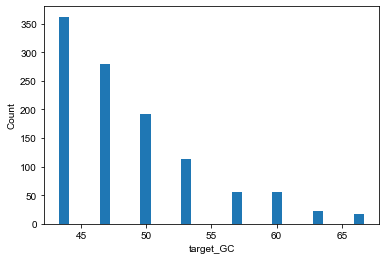

C9orf72_manual
	Variant-3: 1034 / 1096 probes passed the filter 50 < target_Tm <  inf.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


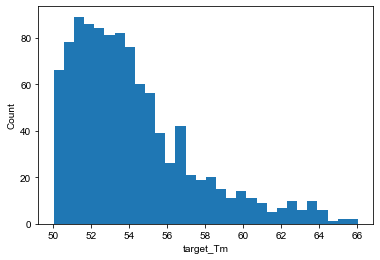

Calculate OTs for 0/1 genes.
C9orf72_manual


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	Variant-3: 1034 / 1034 probes passed the filter -inf < target_OT_rtRNA <  0.5.


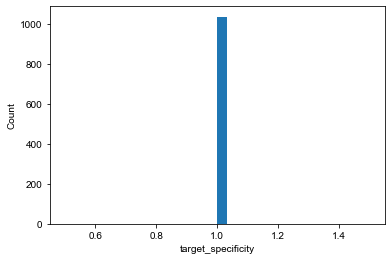

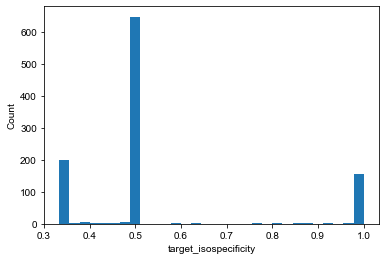

C9orf72_manual
	Variant-3: 1034 / 1034 probes passed the filter 0.99 < target_specificity <  inf.


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


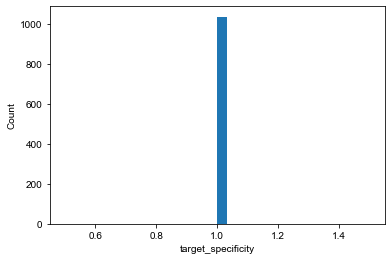

C9orf72_manual
	Variant-3: 157 / 1034 probes passed the filter 0.99 < target_isospecificity <  inf.


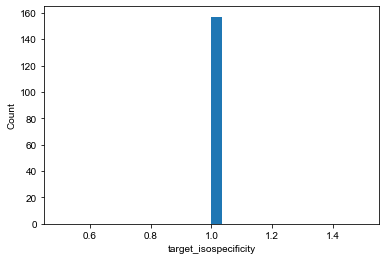

             name         id barcode_str
0  C9orf72_manual  Variant-3    00000011


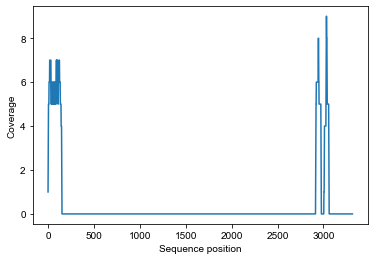

Calculate OTs for 0/1 genes.


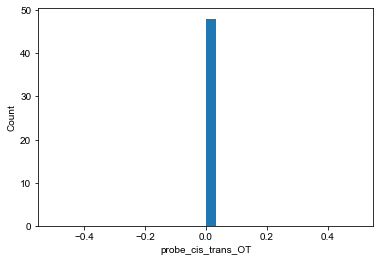

In [366]:
probe_dict = p_d.init_probe_dict(['C9orf72_manual'], 
                                 transcriptome, 'gene_short_name', K=30)
p_d.print_probe_dict(probe_dict)

# Select the transcripts that we want to target
# The target transcripts are already defined in the codebook
probe_dict = p_d.select_transcripts_by_ids(probe_dict, transcript_ids=['Variant-3'])
p_d.print_probe_dict(probe_dict) # We excluded all the transcripts that are not our direct targets

%matplotlib inline

# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
#plot.plot_hist(probe_dict, column_key='target_GC')
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC')

# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
#plot.plot_hist(probe_dict, column_key='target_Tm')
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50)
plot.plot_hist(probe_dict, column_key='target_Tm')

# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')


# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_isospecificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_isospecificity')

# add readouts
# Generate a codebook table for the target transcript
# Choose one of the full length protein coding transcript as the target

merfish_readout_df = pd.read_excel(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts\MERFISH_readouts\readout_table_v2_corrected.xls')

readout_seqs = pd.DataFrame()
readout_seqs['id'] = merfish_readout_df['Probe name']
readout_seqs['sequence'] = merfish_readout_df['Sequence']
readout_seqs['on-bit'] = merfish_readout_df.index
#print(readout_seqs)
barcode_table = pd.DataFrame({'name':['C9orf72_manual'], 
                              'id':['Variant-3'], 
                              'barcode_str':['00000011']})
print(barcode_table)

# Add the readout sequences. Here we randomly add 2 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
rs.add_readout_seqs_to_probes_random(probe_dict, readout_seqs, barcode_table, 2, 
                                     spacer='T', gene_id_key='name', each_probe_1_on_bit=True)

# Select probes by a stochastic greedy algorithms that optimizes the on-bit coverage
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=48, N_on_bits=2)
#ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=12, N_on_bits=2)

# Let's plot the probe coverage of an example transcript
seq_len = len(transcriptome[transcriptome['transcript_id'] == 'Variant-3'].iloc[0]['sequence'])
plot.plot_sequence_coverage(probe_dict['C9orf72_manual']['Variant-3'], seq_len)

# Filter out the probes that self complement or complement with other probes.

# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(probe_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(probe_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(probe_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(probe_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(probe_dict, 'probe_cis_trans_OT')


In [367]:
final_probe_dict['C9orf72_manual'].update(probe_dict['C9orf72_manual'].copy())
final_probe_dict['C9orf72_manual']['Variant-3']

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,probe_cis_trans_OT
38,C9orf72_manual,Variant-3,38,cacgtaaaagatgacgcttggtgtgtcagc,50.000000,53.155882,0,1.0,1.0,RS0255::RS0255,00000001,TCCTATTCTCAACCTAACCTTcacgtaaaagatgacgcttggtgtg...,0
112,C9orf72_manual,Variant-3,112,caagagcaggtgtgggtttaggagatatct,46.666667,52.639743,0,1.0,1.0,RS0247::RS0247,00000010,ACCCTTTACAAACACACCCTTcaagagcaggtgtgggtttaggaga...,0
3032,C9orf72_manual,Variant-3,3032,ggacagcttgatgttttagacaaccactga,43.333333,50.952024,0,1.0,1.0,RS0247::RS0247,00000010,ACCCTTTACAAACACACCCTTggacagcttgatgttttagacaacc...,0
2921,C9orf72_manual,Variant-3,2921,ataaaggtaatagagcccttctgcccccca,50.000000,57.978080,0,1.0,1.0,RS0255::RS0255,00000001,TCCTATTCTCAACCTAACCTTataaaggtaatagagcccttctgcc...,0
74,C9orf72_manual,Variant-3,74,tgctgcccggttgcttctcttttgggggcg,63.333333,63.270027,0,1.0,1.0,RS0255::RS0255,00000001,TCCTATTCTCAACCTAACCTTtgctgcccggttgcttctcttttgg...,0
4,C9orf72_manual,Variant-3,4,aagagaggtgcgtcaaacagcgacaagttc,50.000000,53.584045,0,1.0,1.0,RS0247::RS0247,00000010,ACCCTTTACAAACACACCCTTaagagaggtgcgtcaaacagcgaca...,0
3004,C9orf72_manual,Variant-3,3004,gctttcccatcatgaatcagaaagatgtgg,43.333333,50.108695,0,1.0,1.0,RS0247::RS0247,00000010,ACCCTTTACAAACACACCCTTgctttcccatcatgaatcagaaaga...,0
2946,C9orf72_manual,Variant-3,2946,ccccacccaccaaatttacacaacaaaatg,43.333333,53.053242,0,1.0,1.0,RS0255::RS0255,00000001,TCCTATTCTCAACCTAACCTTccccacccaccaaatttacacaaca...,0
121,C9orf72_manual,Variant-3,121,gtgtgggtttaggagatatctccggagcat,50.000000,54.634555,0,1.0,1.0,RS0255::RS0255,00000001,TCCTATTCTCAACCTAACCTTgtgtgggtttaggagatatctccgg...,0
88,C9orf72_manual,Variant-3,88,ttctcttttgggggcggggtctagcaagag,56.666667,59.056214,0,1.0,1.0,RS0247::RS0247,00000010,ACCCTTTACAAACACACCCTTttctcttttgggggcggggtctagc...,0


In [368]:
del(probe_dict)

# Quality check

Calculate OTs for 0/1 genes.


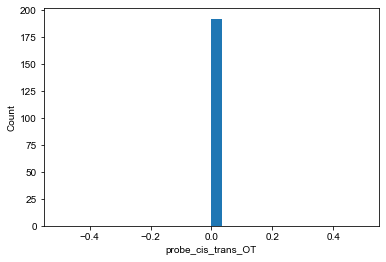

Wall time: 177 ms


In [369]:
%%time
# Filter out the probes that self complement or complement with other probes.

# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(final_probe_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(final_probe_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(final_probe_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(final_probe_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(final_probe_dict, 'probe_cis_trans_OT')

In [371]:
# Get the reverse-complementary sequences of the designed probes
p_d.get_rc_sequences(final_probe_dict, 'target_readout_sequence', 'target_readout_sequence_rc')

# Get a data frame of all probes
df_all_probes = p_d.probe_dict_to_df(final_probe_dict).sort_values(['probe_barcode', 'shift'])

# Make a column of probe names
probe_names = np.array(df_all_probes['gene_id']) + '_' + np.array(df_all_probes['transcript_id'])
probe_names = probe_names + '_shift:' + np.array(df_all_probes['shift']).astype(str)
probe_names = probe_names + '_GC:' + np.array(df_all_probes['target_GC']).astype('|S4').astype(str)
probe_names = probe_names + '_Tm:' + np.array(df_all_probes['target_Tm']).astype('|S4').astype(str)
probe_names = probe_names + '_specificity:' + np.array(df_all_probes['target_specificity']).astype('|S1').astype(str)
probe_names = probe_names + '_isospecificity:' + np.array(df_all_probes['target_isospecificity']).astype('|S4').astype(str)
probe_names = probe_names + '_' + np.array(df_all_probes['readout_names'])
df_all_probes['probe_names'] = probe_names

# Write the designed probes
print(probe_output_file)
df_all_probes.to_csv(probe_output_file, index=False)

I:\MERFISH_LibraryDesign\hc9orf72\designed_probes.csv


E:\Users\puzheng\Documents\MERFISH_probe_design\MERFISH_probe_design\probe_design\probe_dict.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(probe_dict[gk][tk], ignore_index=True)


In [372]:
df_all_probes

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,probe_cis_trans_OT,target_readout_sequence_rc,probe_names
161,C9orf72_manual,Variant-3,0,aggaaagagaggtgcgtcaaacagcgacaa,50.000000,54.996576,0,1.0,1.000000,RS0255::RS0255,00000001,TCCTATTCTCAACCTAACCTTaggaaagagaggtgcgtcaaacagc...,0,AGGTTAGGTTGAGAATAGGAAttgtcgctgtttgacgcacctctct...,C9orf72_manual_Variant-3_shift:0_GC:50.0_Tm:54...
170,C9orf72_manual,Variant-3,1,ggaaagagaggtgcgtcaaacagcgacaag,53.333333,54.426919,0,1.0,1.000000,RS0255::RS0255,00000001,TCCTATTCTCAACCTAACCTTggaaagagaggtgcgtcaaacagcg...,0,AGGTTAGGTTGAGAATAGGAActtgtcgctgtttgacgcacctctc...,C9orf72_manual_Variant-3_shift:1_GC:53.3_Tm:54...
190,C9orf72_manual,Variant-3,3,aaagagaggtgcgtcaaacagcgacaagtt,46.666667,53.439296,0,1.0,1.000000,RS0255::RS0255,00000001,TCCTATTCTCAACCTAACCTTaaagagaggtgcgtcaaacagcgac...,0,AGGTTAGGTTGAGAATAGGAAaacttgtcgctgtttgacgcacctc...,C9orf72_manual_Variant-3_shift:3_GC:46.6_Tm:53...
177,C9orf72_manual,Variant-3,17,caaacagcgacaagttccgcccacgtaaaa,50.000000,55.726732,0,1.0,1.000000,RS0255::RS0255,00000001,TCCTATTCTCAACCTAACCTTcaaacagcgacaagttccgcccacg...,0,AGGTTAGGTTGAGAATAGGAAttttacgtgggcggaacttgtcgct...,C9orf72_manual_Variant-3_shift:17_GC:50.0_Tm:5...
184,C9orf72_manual,Variant-3,30,gttccgcccacgtaaaagatgacgcttggt,53.333333,57.161662,0,1.0,1.000000,RS0255::RS0255,00000001,TCCTATTCTCAACCTAACCTTgttccgcccacgtaaaagatgacgc...,0,AGGTTAGGTTGAGAATAGGAAaccaagcgtcatcttttacgtgggc...,C9orf72_manual_Variant-3_shift:30_GC:53.3_Tm:5...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,C9orf72_manual,3variants_shared,561,ttccaatgcttactggagaagtgattcctg,43.333333,50.964400,0,1.0,0.333333,RS0015::RS0015,10000000,ATCCTCCTTCAATACATCCCTttccaatgcttactggagaagtgat...,0,GGGATGTATTGAAGGAGGATAcaggaatcacttctccagtaagcat...,C9orf72_manual_3variants_shared_shift:561_GC:4...
2,C9orf72_manual,3variants_shared,563,ccaatgcttactggagaagtgattcctgta,43.333333,51.024936,0,1.0,0.333333,RS0015::RS0015,10000000,ATCCTCCTTCAATACATCCCTccaatgcttactggagaagtgattc...,0,GGGATGTATTGAAGGAGGATAtacaggaatcacttctccagtaagc...,C9orf72_manual_3variants_shared_shift:563_GC:4...
40,C9orf72_manual,3variants_shared,574,tggagaagtgattcctgtaatggaactgct,43.333333,51.856842,0,1.0,0.333333,RS0015::RS0015,10000000,ATCCTCCTTCAATACATCCCTtggagaagtgattcctgtaatggaa...,0,GGGATGTATTGAAGGAGGATAagcagttccattacaggaatcactt...,C9orf72_manual_3variants_shared_shift:574_GC:4...
16,C9orf72_manual,3variants_shared,575,ggagaagtgattcctgtaatggaactgctt,43.333333,50.969004,0,1.0,0.333333,RS0015::RS0015,10000000,ATCCTCCTTCAATACATCCCTggagaagtgattcctgtaatggaac...,0,GGGATGTATTGAAGGAGGATAaagcagttccattacaggaatcact...,C9orf72_manual_3variants_shared_shift:575_GC:4...


## used readouts

In [388]:
used_readouts = []
for _rinfo in df_all_probes['readout_names']:
    _rds = [_r for _r in _rinfo.split(':') if len(_r) > 0]
    for _r in _rds:
        if _r not in used_readouts:
            used_readouts.append(_r)    
print(used_readouts)

['RS0255', 'RS0247', 'RS0237', 'RS0175', 'RS0109', 'RS0095', 'RS0083', 'RS0015']


In [395]:
sel_readout_df = merfish_readout_df[[_r in used_readouts for _r in merfish_readout_df['Probe name']]]

In [396]:
sel_readout_df.to_csv(os.path.join(library_folder, 'used_readouts.csv'), index=False)

In [385]:
_rds

['RS0255', 'RS0255']

In [373]:
np.unique(df_all_probes['readout_names'])

array(['RS0015::RS0015', 'RS0083::RS0083', 'RS0095::RS0095',
       'RS0109::RS0109', 'RS0175::RS0175', 'RS0237::RS0237',
       'RS0247::RS0247', 'RS0255::RS0255'], dtype=object)

In [374]:
np.unique(df_all_probes['transcript_id'])

array(['2_3_shared', '3variants_shared', 'Variant-1_lack of Exon1a',
       'Variant-3'], dtype=object)

# map to DNA

In [375]:
full_dna_seq = r'ctgcagcaggtcattttagcaactattagataaaactggtctcaggtcacaacgggcagttgcagcagctggacttggagagaattacactgtgggagcagtgtcatttgtcctaagtgcttttctaccccctacccccactattttagttgggtataaaaagaatgacccaatttgtatgatcaactttcacaaagcatagaacagtaggaaaagggtctgtttctgcagaaggtgtagacgttgagagccattttgtgtatttattcctccctttcttcctcggtgaatgattaaaacgttctgtgtgatttttagtgatgaaaaagattaaatgctactcactgtagtaagtgccatctcacacttgcagatcaaaaggcacacagtttaaaaaacctttgtttttttacacatctgagtggtgtaaatgctactcatctgtagtaagtggaatctatacacctgcagaccaaaagacgcaaggtttcaaaaatctttgtgttttttacacatcaaacagaatggtacgtttttcaaaagttaaaaaaaaacaactcatccacatattgcaactagcaaaaatgacattccccagtgtgaaaatcatgcttgagagaattcttacatgtaaaggcaaaattgcgatgactttgcaggggaccgtgggattcccgcccgcagtgccggagctgtcccctaccagggtttgcagtggagttttgaatgcacttaacagtgtcttacggtaaaaacaaaatttcatccaccaattatgtgttgagcgcccactgcctaccaagcacaaacaaaaccattcaaaaccacgaaatcgtcttcactttctccagatccagcagcctcccctattaaggttcgcacacgctattgcgccaacgctcctccagagcgggtcttaagataaaagaacaggacaagttgccccgccccatttcgctagcctcgtgagaaaacgtcatcgcacatagaaaacagacagACGTAACCTACGGTGTCCCGCTAGGAAAGAGAGGTGCGTCAAACAGCGACAAGTTCCGCCCACGTAAAAGATGACGCTTGGTGTGTCAGCCGTCCCTGCTGCCCGGTTGCTTCTCTTTTGGGGGCGGGGTCTAGCAAGAGCAGGTGTGGGTTTAGGAGgtgtgtgtttttgtttttcccaccctctctccccactacttgctctcacagtactcgctgagggtgaacaagaaaagacctgataaagattaaccagaagaaaacaaggagggaaacaaccgcagcctgtagcaagctctggaactcaggagtcgcgcgctaggggccggggccggggccggggcgtggtcggggcgggcccgggggcgggcccggggcggggctgcGGTTGCGGTGCCTGCGCCCGCGGCGGCGGAGGCGCAGGCGGTGGCGAGTGGgtgagtgaggaggcggcatcctggcgggtggctgtttggggttcggctgccgggaagaggcgcgggtagaagcgggggctctcctcagagctcgacgcatttttactttccctctcatttctctgaccgaagctgggtgtcgggctttcgcctctagcgactggtggaattgcctgcatccgggccccgggcttcccggcggcggcggcggcggcggcggcgcagggacaagggatggggatctggcctcttccttgctttcccgccctcagtacccgagctgtctccttcccggggacccgctgggagcgctgccgctgcgggctcgagaaaagggagcctcgggtactgagaggcctcgcctgggggaaggccggagggtgggcggcgcgcggcttctgcggaccaagtcggggttcgctaggaacccgagacggtccctgccggcgaggagatcatgcgggatgagatgggggtgtggagacgcctgcacaatttcagcccaagcttctagagagtggtgatgacttgcatatgagggcagcaatgcaagtcggtgtgctccccattctgtgggacatgacctggttgcttcacagctccgagatgacacagacttgcttaaaggaagtgactattgtgacttgggcatcacttgactgatggtaatcagttgtctaaagaagtgcacagattacatgtccgtgtgctcattgggtctatctggccgcgttgaacaccaccaggctttgtattcagaaacaggagggaggtcctgcactttcccaggaggggtggccctttcagatgcaatcgagattgttaggctctgggagagtagttgcctggttgtggcagttggtaaatttctattcaaacagttgccatgcaccagttgttcacaacaagggtacgtaatctgtctggcattacttctacttttgtacaaaggatcaaaaaaaaaaaagatactgttaagatatgatttttctcagactttgggaaacttttaacataatctgtgaatatcacagaaacaagactatcatataggggatattaataacctggagtcagaatacttgaaatacggtgtcatttgacacgggcattgttgtcaccacctctgccaaggcctgccactttaggaaaaccctgaatcagttggaaactgctacatgctgatagtacatctgaaacaagaacgagagtaattaccacattccagattgttcactaagccagcatttacctgctccaggaaaaaattacaagcaccttatgaagttgataaaatattttgtttggctatgttggcactccacaatttgctttcagagaaacaaagtaaaccaaggaggacttctgtttttcaagtctgccctcgggttctattctacgttaattagatagttcccaggaggactaggttagcctacctattgtctgagaaacttggaactgtgagaaatggccagatagtgatatgaacttcaccttccagtcttccctgatgttgaagattgagaaagtgttgtgaactttctggtactgtaaacagttcactgtccttgaagtggtcctgggcagctcctgttgtggaaagtggacggtttaggatcctgcttctctttgggctgggagaaaataaacagcatggttacaagtattgagagccaggttggagaaggtggcttacacctgtaatgccagagctttgggaggcggaggcaagaggatcacttgaagccaggagttcaagctcaacctgggcaacgtagaccctgtctctacaaaaaattaaaaacttagccgggcgtggtgatgtgcacctgtagtcctagctacttgggaggctgaggcaggagggtcatttgagcccaagagtttgaagttaccgagagctatgatcctgccagtgcattccagcctggatgacaaaacgagaccctgtctctaaaaaacaagaagtgagggctttatgattgtagaattttcactacaatagcagtggaccaaccacctttctaaataccaatcagggaagagatggttgattttttaacagacgtttaaagaaaaagcaaaacctcaaacttagcactctactaacagttttagcagatgttaattaatgtaatcatgtctgcatgtatgggattatttccagaaagtgtattgggaaacctctcatgaaccctgtgagcaagccaccgtctcactcaatttgaatcttggcttccctcaaaagactggctaatgtttggtaactctctggagtagacagcactacatgtacgtaagataggtacataaacaactattggttttgagctgatttttttcagctgcatttgcatgtatggatttttctcaccaaagacgatgacttcaagtattagtaaaataattgtacagctctcctgattatacttctctgtgacatttcatttcccaggctatttcttttggtaggatttaaaactaagcaattcagtatgatctttgtccttcattttctttcttattctttttgtttgtttgtttgtttgtttttttcttgaggcagagtctctctctgtcgcccaggctggagtgcagtggcgccatctcagctcattgcaacctctgccacctccgggttcaagagattctcctgcctcagcctcccgagtagctgggattacaggtgtccaccaccacacccggctaattttttgtatttttagtagaggtggggtttcaccatgttggccaggctggtcttgagctcctgacctcaggtgatccacctgcctcggcctaccaaagagctgggataacaggtgtgacccaccatgcccggcccattttttttttcttattctgttaggagtgagagtgtaactagcagtataatagttcaattttcacaacgtggtaaaagtttccctataattcaatcagattttgctccagggttcagttctgttttaggaaatacttttattttcagtttaatgatgaaatattagagttgtaatattgcctttatgattatccacctttttaacctaaaagaatgaaagaaaaatatgtttgcaatataattttatggttgtatgttaacttaattcattatgttggcctccagtttgctgttgttagttatgacagcagtagtgtcattaccatttcaattcagattacattcctatatttgatcattgtaaactgactgcttacattgtattaaaaacagtggatattttaaagaagctgtacggcttatatctagtgctgtctcttaagactattaaattgatacaacatatttaaaagtaaatattacctaaatgaatttttgaaattacaaatacacgtgttaaaactgtcgttgtgttcaaccatttctgtacatacttagagttaactgttttgccaggctctgtatgcctactcataatatgataaaagcactcatctaatgctctgtaaatagaagtcagtgctttccatcagactgaactctcttgacaagatgtggatgaaattctttaagtaaaattgtttactttgtcatacatttacagatcaaatgttagctcccaaagcaatcatatggcaaagataggtatatcatagtttgcctattagctgctttgtattgctattattataaatagacttcacagttttagacttgcttaggtgaaattgcaattctttttactttcagtcttagataacaagtcttcaattatagtacaatcacacattgcttaggaatgcatcattaggcgattttgtcattatgcaaacatcatagagtgtacttacacaaacctagatagtatagcctttatgtacctaggccgtatggtatagtctgttgctcctaggccacaaacctgtacaactgttactgtactgaatactatagacagttgtaacacagtggtaaatatttatctaaatatatgcaaacagagaaaaggtacagtaaaagtatggtataaaagataatggtatacctgtgtaggccacttaccacgaatggagcttgcaggactagaagttgctctgggtgagtcagtgagtgagtggtgaattaatgtgaaggcctagaacactgtacaccactgtagactataaacacagtacgctgaagctacaccaaatttatcttaacagtttttcttcaataaaaaattataactttttaactttgtaaactttttaattttttaacttttaaaatacttagcttgaaacacaaatacattgtatagctatacaaaaatattttttctttgtatccttattctagaagcttttttctattttctattttaaatttttttttttacttgttagtcgtttttgttaaaaactaaaacacacacactttcacctaggcatagacaggattaggatcatcagtatcactcccttccacctcactgccttccacctccacatcttgtcccactggaaggtttttaggggcaataacacacatgtagctgtcacctatgataacagtgctttctgttgaatacctcctgaaggacttgcctgaggctgttttacatttaacttaaaaaaaaaaaaagtagaaggagtgcactctaaaataacaataaaaggcatagtatagtgaatacataaaccagcaatgtagtagtttattatcaagtgttgtacactgtaataattgtatgtgctatactttaaataacttgcaaaatagtactaagaccttatgatggttacagtgtcactaaggcaatagcatattttcaggtccattgtaatctaatgggactaccatcatatatgcagtctaccattgactgaaacgttacatggcacataactgtatttgcaagaatgatttgttttacattaatatcacataggatgtacctttttagagtggtatgtttatgtggattaagatgtacaagttgagcaaggggaccaagagccctgggttctgtcttggatgtgagcgtttatgttcttctcctcatgtctgttttctcattaaattcaaaggcttgaacgggccctatttagcccttctgttttctacgtgttctaaataactaaagcttttaaattctagccatttagtgtagaactctctttgcagtgatgaaatgctgtattggtttcttggctagcatattaaatatttttatctttgtcttgatacttcaatgtcgttttaaacatcaggatcgggcttcagtattctcataaccagagagttcactgaggatacaggactgtttgcccattttttgttatggctccagacttgtggtatttccatgtctttttttttttttttttttttgaccttttagcggctttaaagtatttctgttgttaggtgttgtattacttttctaagattacttaacaaagcaccacaaactgagtggctttaaacaacagcaatttattctctcacaattctagaagctagaagtccgaaatcaaagtgttgacaggggcatgatcttcaagagagaagactctttccttgcctcttcctggcttctggtggttaccagcaatcctgagtgttcctttcttgccttgtagtttcaacaatccagtatctgccttttgtcttcacatggctgtctaccatttgtctctgtgtctccaaatctctctccttataaacacagcagttattggattaggccccactctaatccagtatgaccccattttaacatgattacacttatttctagataaggtcacattcacgtacaccaagggttaggaattgaacatatctttttgggggacacaattcaacccacaagtgtcagtctctagctgagcctttcccttcctgtttttctcctttttagttgctatgggttaggggccaaatctccagtcatactagaattgcacatggactggatatttgggaatactgcgggtctattctatgagctttagtatgtaacatttaatatcagtgtaaagaagcccttttttaagttatttctttgaatttctaaatgtatgccctgaatataagtaacaagttaccatgtcttgtaaaatgatcatatcaacaaacatttaatgtgcacctactgtgctagttgaatgtctttatcctgataggagataacaggattccacatctttgacttaagaggacaaaccaaatatgtctaaatcatttggggttttgatggatatctttaaattgctgaacctaatcattggtttcatatgtcattgtttagATATCTCCGGAGCATTTGGATAATGTGACAGTTGGAATGCAGTGATGTCGACTCTTTGCCCACCGCCATCTCCAGCTGTTGCCAAGACAGAGATTGCTTTAAGTGGCAAATCACCTTTATTAGCAGCTACTTTTGCTTACTGGGACAATATTCTTGGTCCTAGAGTAAGGCACATTTGGGCTCCAAAGACAGAACAGGTACTTCTCAGTGATGGAGAAATAACTTTTCTTGCCAACCACACTCTAAATGGAGAAATCCTTCGAAATGCAGAGAGTGGTGCTATAGATGTAAAGTTTTTTGTCTTGTCTGAAAAGGGAGTGATTATTGTTTCATTAATCTTTGATGGAAACTGGAATGGGGATCGCAGCACATATGGACTATCAATTATACTTCCACAGACAGAACTTAGTTTCTACCTCCCACTTCATAGAGTGTGTGTTGATAGATTAACACATATAATCCGGAAAGGAAGAATATGGATGCATAAGgtaagtgatttttcagcttattaatcatgttaacctatctgttgaaagcttattttctggtacatataaatcttatttttttaattatatgcagtgaacatcaaacaataaatgttatttattttgcatttaccctattagatacaaatacatctggtctgatacctgtcatcttcatattaactgtggaaggtacgaaatggtagctccacattatagatgaaaagctaaagcttagacaaataaagaaacttttagaccctggattcttcttgggagcctttgactctaataccttttgtttccctttcattgcacaattctgtcttttgcttactactatgtgtaagtataacagttcaaagtaatagtttcataagctgttggtcatgtagcctttggtctctttaacctctttgccaagttcccaggttcataaaatgaggaggttgaatggaatggttcccaagagaattccttttaatcttacagaaattattgttttcctaaatcctgtagttgaatatataatgctatttacatttcagtatagttttgatgtatctaaagaacacattgaattctccttcctgtgttccagtttgatactaacctgaaagtccattaagcattaccagttttaaaaggcttttgcccaatagtaaggaaaaataatatcttttaaaagaataattttttactatgtttgcaggcttacttccttttttctcacattatgaaactcttaaaatcaggagaatcttttaaacaacatcataatgtttaatttgaaaagtgcaagtcattcttttcctttttgaaactatgcagatgttacattgactgttttctgtgaagttatctttttttcactgcagaataaaggttgttttgattttattttgtattgtttatgagaacatgcatttgttgggttaatttcctacccctgcccccattttttccctaaagtagaaagtatttttcttgtgaactaaattactacacaagaacatgtctattgaaaaataagcaagtatcaaaatgttgtgggttgtttttttaaataaattttctcttgctcagGAAAGACAAGAAAATGTCCAGAAGATTATCTTAGAAGGCACAGAGAGAATGGAAGATCAGgtatatgcaaattgcatactgtcaaatgtttttctcacagcatgtatctgtataaggttgatggctacatttgtcaaggccttggagacatacgaataagcctttaatggagcttttatggaggtgtacagaataaactggaggaagatttccatatcttaaacccaaagagttaaatcagtaaacaaaggaaaatagtaattgcatctacaaattaatatttgctccctttttttttctgtttgcccagaataaattttggataacttgttcatagtaaaaataaaaaaaattgtctctgatatgttctttaaggtactacttctcgaacctttccctagaagtagctgtaacagaaggagagcatatgtacccctgaggtatctgtctggggtgtaggcccaggtccacacaatatttcttctaagtcttatgttgtatcgttaagactcatgcaatttacattttattccataactattttagtattaaaatttgtcagtgatatttcttaccctctcctctaggaaaatgtgccatgtttatcccttggctttgaatgcccctcaggaacagacactaagagtttgagaagcatggttacaagggtgtggcttcccctgcggaaactaagtacagactatttcactgtaaagcagagaagttcttttgaaggagaatctccagtgaagaaagagttcttcacttttacttccatttcctcttgtgggtgaccctcaatgctccttgtaaaactccaatattttaaacatggctgttttgcctttctttgcttctttttagcatgaatgagacagatgatactttaaaaaagtaattaaaaaaaaaaacttgtgaaaatacatggccataatacagaacccaatacaatgatctcctttaccaaattgttatgtttgtacttttgtagatagctttccaattcagagacagttattctgtgtaaaggtctgacttaacaagaaaagatttccctttacccaaagaatcccagtccttatttgctggtcaataagcagggtccccaggaatggggtaactttcagcaccctctaacccactagttattagtagactaattaagtaaacttatcgcaagttgaggaaacttagaaccaactaaaattctgcttttactgggattttgttttttcaaaccagaaacctttacttaagttgactactattaatgaattttggtctctcttttaagtgctcttcttaaaaatgttatcttactgctgagaagttcaagtttgggaagtacaaggaggaatagaaacttaagagattttcttttagagcctcttctgtatttagccctgtaggatttttttttttttttttttttttggtgttgttgagcttcagtgaggctattcattcacttatactgataatgtctgagatactgtgaatgaaatactatgtatgcttaaacctaagaggaaatattttcccaaaattattcttcccgaaaaggaggagttgccttttgattgagttcttgcaaatctcacaacgactttattttgaacaatactgtttggggatgatgcattagtttgaaacaacttcagttgtagctgtcatctgataaaattgcttcacagggaaggaaatttaacacggatctagtcattattcttgttagattgaatgtgtgaattgtaattgtaaacaggcatgataattattactttaaaaactaaaaacagtgaatagttagttgtggaggttactaaaggatggtttttttttaaataaaactttcagcattatgcaaatgggcatatggcttaggataaaacttccagaagtagcatcacatttaaattctcaagcaacttaataatatggggctctgaaaaactggttaaggttactccaaaaatggccctgggtctgacaaagattctaacttaaagatgcttatgaagactttgagtaaaatcatttcataaaataagtgaggaaaaacaactagtattaaattcatcttaaataatgtatgatttaaaaaatatgtttagctaaaaatgcatagtcatttgacaatttcatttatatctcaaaaaatttacttaaccaagttggtcacaaaactgatgagactggtggtggtagtgaataaatgagggaccatccatatttgagacactttacatttgtgatgtgttatactgaattttcagtttgattctatagactacaaatttcaaaattacaatttcaagatgtaataagtagtaatatcttgaaatagctctaaagggaatttttctgttttattgattcttaaaatatatgtgctgattttgatttgcatttgggtagattatacttttatgagtatggaggttaggtattgattcaagttttccttacctatttggtaaggatttcaaagtctttttgtgcttggttttcctcatttttaaatatgaaatatattgatgacctttaacaaattttttttatctcaaattttaaaggagatcttttctaaaagaggcatgatgacttaatcattgcatgtaacagtaaacgataaaccaatgattccatactctctaaagaataaaagtgagctttagggccgggcatggtcagaaatttgacaccaacctggccaacatggcgaaaccccgtctctactaaaaatacaaaaatcagccgggcatggtggcggcacctatagtcccagctacttgggaggatgagacaggagagtcacttgaacctgggaggagaggttgcagtgagctgagatcacgccattgcactccagcctgagcaatgaaagcaaaactccatctcaaaaaaaaaaaaagaaaagaaagaataaaagtgagctttggattgcatataaatcctttagacatgtagtagacttgtttgatactgtgtttgaacaaattacgaagtattttcatcaaagaatgttattgtttgatgttatttttattttttattgcccagcttctctcatattacgtgattttcttcacttcatgtcactttattgtgcagGGTCAGAGTATTATTCCAATGCTTACTGGAGAAGTGATTCCTGTAATGGAACTGCTTTCATCTATGAAATCACACAGTGTTCCTGAAGAAATAGATgtaagtttaaatgagagcaattatacactttatgagttttttggggttatagtattattatgtatattattaatattctaattttaatagtaaggactttgtcatacatactattcacatacagtattagccactttagcaaataagcacacacaaaatcctggattttatggcaaaacagaggcatttttgatcagtgatgacaaaattaaattcattttgtttatttcattacttttataattcctaaaagtgggaggatcccagctcttataggagcaattaatatttaatgtagtgtcttttgaaacaaaactgtgtgccaaagtagtaaccattaatggaagtttacttgtagtcacaaatttagtttccttaatcatttgttgaggacgttttgaatcacacactatgagtgttaagagatacctttaggaaactattcttgttgttttctgattttgtcatttaggttagtctcctgattctgacagctcagaagaggaagttgttcttgtaaaaattgtttaacctgcttgaccagctttcacatttgttcttctgaagtttatggtagtgcacagagattgttttttggggagtcttgattctcggaaatgaaggcagtgtgttatattgaatccagacttccgaaaacttgtatattaaaagtgttatttcaacactatgttacagccagactaatttttttattttttgatgcattttagATAGCTGATACAGTACTCAATGATGATGATATTGGTGACAGCTGTCATGAAGGCTTTCTTCTCAAgtaagaatttttcttttcataaaagctggatgaagcagataccatcttatgctcacctatgacaagatttggaagaaagaaaataacagactgtctacttagattgttctagggacattacgtatttgaactgttgcttaaatttgtgttatttttcactcattatatttctatatatatttggtgttattccatttgctatttaaagaaaccgagtttccatcccagacaagaaatcatggccccttgcttgattctggtttcttgttttacttctcattaaagctaacagaatcctttcatattaagttgtactgtagatgaacttaagttatttaggcgtagaacaaaattattcatatttatactgatctttttccatccagcagtggagtttagtacttaagagtttgtgcccttaaaccagactccctggattaatgctgtgtacccgtgggcaaggtgcctgaattctctatacacctatttcctcatctgtaaaatggcaataatagtaatagtacctaatgtgtagggttgttataagcattgagtaagataaataatataaagcacttagaacagtgcctggaacataaaaacacttaataatagctcatagctaacatttcctatttacatttcttctagaaatagccagtatttgttgagtgcctacatgttagttcctttactagttgctttacatgtattatcttatattctgttttaaagtttcttcacagttacagattttcatgaaattttacttttaataaaagagaagtaaaagtataaagtattcacttttatgttcacagtcttttcctttaggctcatgatggagtatcagaggcatgagtgtgtttaacctaagagccttaatggcttgaatcagaagcactttagtcctgtatctgttcagtgtcagcctttcatacatcattttaaatcccatttgactttaagtaagtcacttaatctctctacatgtcaatttcttcagctataaaatgatggtatttcaataaataaatacattaattaaatgatattatactgactaattgggctgttttaaggctcaataagaaaatttctgtgaaaggtctctagaaaatgtaggttcctatacaaataaaagataacattgtgcttatagcttcggtgtttatcatataaagctattctgagttatttgaagagctcacctacttttttttgtttttagtttgttaaattgttttataggcaatgtttttaatctgttttctttaacttacagTGCCATCAGCTCACACTTGCAAACCTGTGGCTGTTCCGTTGTAGTAGGTAGCAGTGCAGAGAAAGTAAATAAGgtagtttattttataatctagcaaatgatttgactctttaagactgatgatatatcatggattgtcatttaaatggtaggttgcaattaaaatgatctagtagtataaggaggcaatgtaatctcatcaaattgctaagacaccttgtggcaacagtgagtttgaaataaactgagtaagaatcatttatcagtttattttgatagctcggaaataccagtgtcagtagtgtataaatggttttgagaatatattaaaatcagatatataaaaaaaattactcttctatttcccaatgttatctttaacaaatctgaagatagtcatgtacttttggtagtagttccaaagaaatgttatttgtttattcatcttgatttcattgtcttcgctttccttctaaatctgtcccttctagggagctattgggattaagtggtcattgattattatactttattcagtaatgtttctgaccctttccttcagtgctacttgagttaattaaggattaatgaacagttacatttccaagcattagctaataaactaaaggattttgcacttttcttcactgaccattagttagaaagagttcagagataagtatgtgtatctttcaatttcagcaaacctaattttttaaaaaaagttttacataggaaatatgttggaaatgatactttacaaagatattcataatttttttttgtaatcagctactttgtatatttacatgagccttaatttatatttctcatataaccatttatgagagcttagtatacctgtgtcattatattgcatctacgaactagtgaccttattccttctgttacctcaaacaggtggctttccatctgtgatctccaaagccttaggttgcacagagtgactgccgagctgctttatgaagggagaaaggctccatagttggagtgtttttttttttttttttaaacatttttcccatcctccatcctcttgagggagaatagcttaccttttatcttgttttaatttgagaaagaagttgccaccactctaggttgaaaaccactcctttaacataataactgtggatatggtttgaatttcaagatagttacatgcctttttatttttcctaatagagctgtaggtcaaatattattagaatcagatttctaaatcccacccaatgacctgcttattttaaatcaaattcaataattaattctcttctttttggaggatctggacattctttgatatttcttacaacgaatttcatgtgtagacccactaaacagaagctataaaagttgcatggtcaaataagtctgagaaagtctgcagatgatataattcacctgaagagtcacagtatgtagccaaatgttaaaggttttgagatgccatacagtaaatttaccaagcattttctaaatttatttgaccacagaatccctattttaagcaacaactgttacatcccatggattccaggtgactaaagaatacttatttcttaggatatgttttattgataataacaattaaaatttcagatatctttcataagcaaatcagtggtctttttacttcatgttttaatgctaaaatattttcttttatagATAGTCAGAACATTATGCCTTTTTCTGACTCCAGCAGAGAGAAAATGCTCCAGGTTATGTGAAGCAGAATCATCATTTAAATATGAGTCAGGGCTCTTTGTACAAGGCCTGCTAAAGgtatagtttctagttatcacaagtgaaaccacttttctaaaatcatttttgagactctttatagacaaatcttaaatattagcatttaatgtatctcatattgacatgcccagagactgacttcctttacacagttctgcacatagactatatgtcttatggatttatagttagtatcatcagtgaaacaccatagaataccctttgtgttccaggtgggtccctgttcctacatgtctagcctcaggacttttttttttttaacacatgcttaaatcaggttgcacatcaaaaataagatcatttctttttaactaaatagatttgaattttattgaaaaaaaattttaaacatctttaagaagcttataggatttaagcaattcctatgtatgtgtactaaaatatatatatttctatatataatatatattagaaaaaaattgtatttttcttttatttgagtctactgtcaaggagcaaaacagagaaatgtaaattagcaattatttataatacttaaagggaagaaagttgttcaccttgttgaatctattattgttatttcaattatagtcccaagacgtgaagaaatagctttcctaatggttatgtgattgtctcatagtgactactttcttgaggatgtagccacggcaaaatgaaataaaaaaatttaaaaattgttgcaaatacaagttatattaggcttttgtgcattttcaataatgtgctgctatgaactcagaatgatagtatttaaatatagaaactagttaaaggaaacgtagtttctatttgagttatacatatctgtaaattagaacttctcctgttaaaggcataataaagtgcttaatacttttgtttcctcagcaccctctcatttaattatataattttagttctgaaagggacctataccagatgcctagaggaaatttcaaaactatgatctaatgaaaaaatatttaatagttctccatgcaaatacaaatcatatagttttccagaaaatacctttgacattatacaaagatgattatcacagcattataatagtaaaaaaatggaaatagcctctttcttctgttctgttcatagcacagtgcctcatacgcagtaggttattattacatggtaactggctaccccaactgattaggaaagaagtaaatttgttttataaaaatacatactcattgaggtgcatagaataattaagaaattaaaagacacttgtaattttgaatccagtgaatacccactgttaatatttggtatatctctttctagtctttttttcccttttgcatgtattttctttaagactcccacccccactggatcatctctgcatgttctaatctgcttttttcacagcagattctaagcctctttgaatatcaacacaaacttcaacaacttcatctatagatgccaaataataaattcatttttatttacttaaccacttcctttggatgcttaggtcattctgatgttttgctattgaaaccaatgctatactgaacacttctgtcactaaaactttgcacacactcatgaatagcttcttaggataaatttttagagatggatttgctaaatcagagaccattttttaaaattaaaaaacaattattcatatcgtttggcatgtaagacagtaaattttccttttattttgacagGATTCAACTGGAAGCTTTGTGCTGCCTTTCCGGCAAGTCATGTATGCTCCATATCCCACCACACACATAGATGTGGATGTCAATACTGTGAAGCAGATGCCACCCTGTCATGAACATATTTATAATCAGCGTAGATACATGAGATCCGAGCTGACAGCCTTCTGGAGAGCCACTTCAGAAGAAGACATGGCTCAGGATACGATCATCTACACTGACGAAAGCTTTACTCCTGATTTgtacgtaatgctctgcctgctggtactgtagtcaagcaatatgaaattgtgtcttttacgaataaaaacaaaacagaagttgcatttaaaaagaaagaaatattaccagcagaattatgcttgaagaaacatttaatcaagcatttttttcttaaatgttcttctttttccatacaattgtgtttaccctaaaataggtaagattaacccttaaagtaaatatttaactatttgtttaataaatatatattgagctcctaggcactgttctaggtaccgggcttaatagtggccaaccagacagccccagccccagcccctacattgtgtatagtctattatgtaacagttattgaatggacttattaacaaaaccaaagaagtaattctaagtcttttttttcttgacatatgaatataaaatacagcaaaactgttaaaatatattaatggaacatttttttactttgcattttatattgttattcacttcttatttttttttaaaaaaaaaagcctgaacagtaaattcaaaaggaaaagtaatgataattaattgttgagcatggacccaacttgaaaaaaaaaatgatgatgataaatctataatcctaaaaccctaagtaaacacttaaaagatgttctgaaatcaggaaaagaattatagtatacttttgtgtttctcttttatcagttgaaaaaaggcacagtagctcatgcctgtaagaacagagctttgggagtgcaaggcaggcggatcacttgaggccaggagttccagaccagcctgggcaacatagtgaaaccccatctctacaaaaaataaaaaagaattattggaatgtgtttctgtgtgcctgtaatcctagctattccgaaagctgaggcaggaggatcttttgagcccaggagtttgaggttacagggagttatgatgtgccagtgtactccagcctggggaacaccgagactctgtcttatttaaaaaaaaaaaaaaaaaaatgcttgcaataatgcctggcacatagaaggtaacagtaagtgttaactgtaataacccaggtctaagtgtgtaaggcaatagaaaaattggggcaaataagcctgacctatgtatctacagaatcagtttgagcttaggtaacagacctgtggagcaccagtaattacacagtaagtgttaaccaaaagcatagaataggaatatcttgttcaagggacccccagccttatacatctcaaggtgcagaaagatgacttaatataggacccattttttcctagttctccagagtttttattggttcttgagaaagtagtaggggaatgttttagaaaatgaattggtccaactgaaattacatgtcagtaagtttttatatattggtaaattttagtagacatgtagaagttttctaattaatctgtgccttgaaacattttcttttttcctaaagtgcttagtattttttccgttttttgattggttacttgggagcttttttgaggaaatttagtgaactgcagaatgggtttgcaaccatttggtatttttgttttgttttttagaggatgtatgtgtattttaacatttcttaatcatttttagccagctatgtttgttttgctgatttgacaaactacagttagacagctattctcattttgctgatcatgacaaaataatatcctgaatttttaaattttgcatccagctctaaattttctaaacataaaattgtccaaaaaatagtattttcagccactagattgtgtgttaagtctattgtcacagagtcattttacttttaagtatatgtttttacatgttaattatgtttgttatttttaattttaactttttaaaataattccagtcactgccaatacatgaaaaattggtcactggaattttttttttgacttttattttaggttcatgtgtacatgtgcaggtgtgttatacaggtaaattgcgtgtcatgagggtttggtgtacaggtgatttcattacccaggtaataagcatagtacccaataggtagttttttgatcctcacccttctcccaccctcaagtaggccctggtgttgctgtttccttctttgtgtccatgtatactcagtgtttagctcccacttagaagtgagaacatgcggtagttggttttctgttcctggattagttcacttaggataatgacctctagctccatctggtttttatggctgcatagtattccatggtgtatatgtatcacattttctttatccagtctaccattgataggcatttaggttgattccctgtctttgttatcatgaatagtgctgtgatgaacatacacatgcatgtgtctttatggtagaaaaatttgtattcctttaggtacatatagaataatggggttgctagggtgaatggtagttctattttcagttatttgagaaatcttcaaactgcttttcataatagctaaactaatttacagtcccgccagcagtgtataagtgttcccttttctccacaaccttgccaacatctgtgattttttgactttttaataatagccattcctagagaattgatttgcaattctctattagtgatattaagcattttttcatatgctttttagctgtctgtatatattcttctgaaaaattttcatgtcctttgcccagtttgtagtggggtgggttgttttttgcttgttaattagttttaagttccttccagattctgcatatccctttgttggatacatggtttgcagatatttttctcccattgtgtaggttgtcttttactctgttgatagtttcttttgccatgcaggagctcgttaggtcccatttgtgtttgtttttgttgcagttgcttttggcgtcttcatcataaaatctgtgccagggcctatgtccagaatggtatttcctaggttgtcttccagggtttttacaattttagattttacgtttatgtctttaatccatcttgagttgatttttgtatatggcacaaggaaggggtccagtttcactccaattcctatggctagcaattatcccagcaccatttattgaatacggagtcctttccccattgcttgttttttgtcaactttgttgaagatcagatggttgtaagtgtgtggctttatttcttggctctctattctccattggtctatgtgtctgtttttataacagtaccctgctgttcaggttcctatagccttttagtataaaatcggctaatgtgatgcctccagctttgttctttttgcttaggattgctttggctatttgggctcctttttgggtccatattaattttaaaacagttttttctggttttgtgaaggatatcattggtagtttataggaatagcattgaatctgtagattgctttgggcagtatggccattttaacaatattaattcttcctatctatgaatatggaatgtttttccatgtgtttgtgtcatctctttatacctgatgtataaagaaaagctggtattattcctactcaatctgttccaaaaaattgaggaggaggaactcttccctaatgaggccagcatcattctgataccaaaacctggcagagacacaacagaaaaaagaaaacttcaggccaatatccttgatgaatatagatgcaaaaatcctcaacaaaatactagcaaaccaaatccagcagcacatcaaaaagctgatctactttgatcaagtaggctttatccctgggatgcaaggttggttcaacatacacaaatcaataagtgtgattcatcacataaacagagctaaaaacaaaaaccacaagattatctcaataggtagagaaaaggttgtcaataaaatttaacatcctccatgttaaaaaccttcagtaggtcaggtgtagtgactcacacctgtaatcccagcactttgggaggccaaggcgggcatatctcttaagcccaggagttcaagacgagcctaggcagcatggtgaaaccccatctctacaaaaaaaaaaaaaaaaaaaaattagcttggtatggtgacatgcacctatagtcccagctattcaggaggttgaggtgggaggattgtttgagcccgggaggcagaggttggcagcgagctgagatcatgccaccgcactccagcctgggcaacggagtgagaccctgtctcaaaaaagaaaaatcacaaacaatcctaaacaaactaggcattgaaggaacatgcctcaaaaaaataagaaccatctatgacagacccatagccaatatcttaccaaatgggcaaaagctggaagtattctccttgagaaccgtaacaagacaaggatgtccactctcaccactccttttcagcatagttctggaagtcctagccagagcaatcaggaaagagaaagaaagaaagacattcagataggaagagaagaagtcaaactatttctgtttgcaggcagtataattctgtacctagaaaatctcatagtctctgcccagaaactcctaaatctgttaaaaatttcagcaaagttttggcattctctatactccaacaccttccaaagtgagagcaaaatcaagaacacagtcccattcacaatagccgcaaaacgaataaaatacctaggaatccagctaaccagggaggtgaaagatctctatgagaattacaaaacactgctgaaagaaatcagagatgacacaaacaaatggaaatgttcttttttaacaccttgctttatctaattcacttatgatgaagatactcattcagtggaacaggtataataagtccactcgattaaatataagccttattctctttccagagcccaagaaggggcactatcagtgcccagtcaataatgacgaaatgctaatatttttcccctttacggtttctttcttctgtagtgtggtacactcgtttcttaagataaggaaacttgaactaccttcctgtttgcttctacacatacccattctctttttttgccactctggtcaggtataggatgatccctaccactttcagttaaaaactcctcctcttactaaatgttctcttaccctctggcctgagtagaacctagggaaaatggaagagaaaaagatgaaagggaggtggggcctgggaagggaataagtagtcctgtttgtttgtgtgtttgctttagcacctgctatatcctaggtgctgtgttaggcacacattattttaagtggccattatattactactactcactctggtcgttgccaaggtaggtagtactttcttggatagttggttcatgttacttacagatggtgggcttgttgaggcaaacccagtggataatcatcggagtgtgttctctaatctcactcaaatttttcttcacattttttggtttgttttggtttttgatggtagtggcttatttttgttgctggtttgttttttgtttttttttgagatggcaagaattggtagttttatttattaattgcctaagggtctctactttttttaaaagatgagagtagtaaaatagattgatagatacatacatacccttactggggactgcttatattctttagagaaaaaattacatattagcctgacaaacaccagtaaaatgtaaatatatccttgagtaaataaatgaatgtatattttgtgtctccaaatatatatatctatattcttacaaatgtgtttatatgtaatatcaatttataagaacttaaaatgttggctcaagtgagggattgtggaaggtagcattatatggccatttcaacatttgaacttttttcttttcttcattttcttcttttcttcagGAATATTTTTCAAGATGTCTTACACAGAGACACTCTAGTGAAAGCCTTCCTGGATCAGgtaaatgttgaacttgagattgtcagagtgaatgatatgacatgttttcttttttaatatatcctacaatgcctgttctatatatttatattcccctggatcatgccccagagttctgctcagcaattgcagttaagttagttacactacagttctcagaagagtctgtgagggcatgtcaagtgcatcattacattggttgcctcttgtcctagatttatgcttcgggaattcagacctttgtttacaatataataaatattattgctatcttttaaagatataataataagatataaagttgaccacaactactgttttttgaaacatagaattcctggtttacatgtatcaaagtgaaatctgacttagcttttacagatataatatatacatatatatatcctgcaatgcttgtactatatatgtagtacaagtatatatatatgtttgtgtgtgtatatatatatagtacgagcatatatacatattaccagcattgtaggatatatatatgtttatatattaaaaaaaagttataaacttaaaaccctattatgttatgtagagtatatgttatatatgatatgtaaaatatataacatatactctatgatagagtgtaatatattttttatatatattttaacatttataaaatgatagaattaagaattgagtcctaatctgttttattaggtgctttttgtagtgtctggtctttctaaagtgtctaaatgatttttccttttgacttattaatggggaagagcctgtatattaacaattaagagtgcagcattccatacgtcaaacaacaaacattttaattcaagcattaacctataacaagtaagttttttttttttttttgagaaagggaggttgtttatttgcctgaaatgactcaaaaatatttttgaaacatagtgtacttatttaaataacatctttattgtttcattcttttaaaaaatatctacttaattacacagttgaaggaaatcgtagattatatggaacttatttcttaatatattacagtttgttataataacattctggggatcaggccaggaaactgtgtcatagataaagctttgaaataatgagatccttatgtttactagaaattttggattgagatctatgaggtctgtgacatattgcgaagttcaaggaaaattcgtaggcctggaatttcatgcttctcaagctgacataaaatccctcccactctccacctcatcatatgcacacattctactcctacccacccactccaccccctgcaaaagtacaggtatatgaatgtctcaaaaccataggctcatcttctaggagcttcaatgttatttgaagatttgggcagaaaaaattaagtaatacgaaataacttatgtatgagttttaaaagtgaagtaaacatggatgtattctgaagtagaatgcaaaatttgaatgcatttttaaagataaattagaaaacttctaaaaactgtcagattgtctgggcctggtggcttatgcctgtaatcccagcactttgggagtccgaggtgggtggatcacaaggtcaggagatcgagaccatcctgccaacatggtgaaaccccgtctctactaagtatacaaaaattagctgggcgtggcagcgtgtgcctgtaatcccagctacctgggaggctgaggcaggagaatcgcttgaacccaggaggtgtaggttgcagtgagtcaagatcgcgccactgcactttagcctggtgacagagctagactccgtctcaaaaaaaaaaaaaaatatcagattgttcctacacctagtgcttctataccacactcctgttagggggcatcagtggaaatggttaaggagatgtttagtgtgtattgtctgccaagcactgtcaacactgtcatagaaacttctgtacgagtagaatgtgagcaaattatgtgttgaaatggttcctctccctgcagGTCTTTCAGCTGAAACCTGGCTTATCTCTCAGAAGTACTTTCCTTGCACAGTTTCTACTTGTCCTTCACAGAAAAGCCTTGACACTAATAAAATATATAGAAGACGATACgtgagtaaaactcctacacggaagaaaaacctttgtacattgtttttttgttttgtttcctttgtacattttctatatcataatttttgcgcttcttttttttttttttttttttttttttccattatttttagGCAGAAGGGAAAAAAGCCCTTTAAATCTCTTCGGAACCTGAAGATAGACCTTGATTTAACAGCAGAGGGCGATCTTAACATAATAATGGCTCTGGCTGAGAAAATTAAACCAGGCCTACACTCTTTTATCTTTGGAAGACCTTTCTACACTAGTGTGCAAGAACGAGATGTTCTAATGACTTTTTAAATGTGTAACTTAATAAGCCTATTCCATCACAATCATGATCGCTGGTAAAGTAGCTCAGTGGTGTGGGGAAACGTTCCCCTGGATCATACTCCAGAATTCTGCTCTCAGCAATTGCAGTTAAGTAAGTTACACTACAGTTCTCACAAGAGCCTGTGAGGGGATGTCAGGTGCATCATTACATTGGGTGTCTCTTTTCCTAGATTTATGCTTTTGGGATACAGACCTATGTTTACAATATAATAAATATTATTGCTATCTTTTAAAGATATAATAATAGGATGTAAACTTGACCACAACTACTGTTTTTTTGAAATACATGATTCATGGTTTACATGTGTCAAGGTGAAATCTGAGTTGGCTTTTACAGATAGTTGACTTTCTATCTTTTGGCATTCTTTGGTGTGTAGAATTACTGTAATACTTCTGCAATCAACTGAAAACTAGAGCCTTTAAATGATTTCAATTCCACAGAAAGAAAGTGAGCTTGAACATAGGATGAGCTTTAGAAAGAAAATTGATCAAGCAGATGTTTAATTGGAATTGATTATTAGATCCTACTTTGTGGATTTAGTCCCTGGGATTCAGTCTGTAGAAATGTCTAATAGTTCTCTATAGTCCTTGTTCCTGGTGAACCACAGTTAGGGTGTTTTGTTTATTTTATTGTTCTTGCTATTGTTGATATTCTATGTAGTTGAGCTCTGTAAAAGGAAATTGTATTTTATGTTTTAGTAATTGTTGCCAACTTTTTAAATTAATTTTCATTATTTTTGAGCCAAATTGAAATGTGCACCTCCTGTGCCTTTTTTCTCCTTAGAAAATCTAATTACTTGGAACAAGTTCAGATTTCACTGGTCAGTCATTTTCATCTTGTTTTCTTCTTGCTAAGTCTTACCATGTACCTGCTTTGGCAATCATTGCAACTCTGAGATTATAAAATGCCTTAGAGAATATACTAACTAATAAGATCTTTTTTTCAGAAACAGAAAATAGTTCCTTGAGTACTTCCTTCTTGCATTTCTGCCTATGTTTTTGAAGTTGTTGCTGTTTGCCTGCAATAGGCTATAAGGAATAGCAGGAGAAATTTTACTGAAGTGCTGTTTTCCTAGGTGCTACTTTGGCAGAGCTAAGTTATCTTTTGTTTTCTTAATGCGTTTGGACCATTTTGCTGGCTATAAAATAACTGATTAATATAATTCTAACACAATGTTGACATTGTAGTTACACAAACACAAATAAATATTTTATTTAAAATTCTGGAAGTAATATAAAAGGGAAAATATATTTATAAGAAAGGGATAAAGGTAATAGAGCCCTTCTGCCCCCCACCCACCAAATTTACACAACAAAATGACATGTTCGAATGTGAAAGGTCATAATAGCTTTCCCATCATGAATCAGAAAGATGTGGACAGCTTGATGTTTTAGACAACCACTGAACTAGATGACTGTTGTACTGTAGCTCAGTCATTTAAAAAATATATAAATACTACCTTGTAGTGTCCCATACTGTGTTTTTTACATGGTAGATTCTTATTTAAGTGCTAACTGGTTATTTTCTTTGGCTGGTTTATTGTACTGTTATACAGAATGTAAGTTGTACAGTGAAATAAGTTATTAAAGCATGTGTAAACATTGTTATATATCTTTTCTCCTAAATGGAGAATTTTGAATAAAATATATTTGAAATTTTGcctctttcagttgttcattcagaaaaaaatactatgatatttgaagactgatcagcttctgttcagctgacagtcatgctggatctaaactttttttaaaattaattttgtcttttcaaagaaaaaatatttaaagaagctttataatataatcttatgttaaaaaaactttctgcttaactctctggatttcattttgatttttcaaattatatattaatatttcaaatgtaaaatactatttagataaattgtttttaaacattcttattattataatattaatataacctaaactgaagttattcatcccaggtatctaatacatgtatccaaagtaaaaatccaaggaatctgaacactttcatctgcaaagctaggaataggtttgacattttcactccaagaaaaagtttttttttgaaaatagaatagttgggatgagaggtttctttaaaagaagactaactgatcacattactatgattctcaaagaagaaaccaaaacttcatataatactataaagtaaatataaaatagttccttctatagtatatttctataatgctacagtttaaacagatcactcttatataatactattttgattttgatgtagaattgcacaaattgatatttctcctatgatctgcagggtatagcttaaagtaacaaaaacagtcaaccacctccatttaacacacagtaacactatgggactagttttattacttccattttacaaatgaggaaactaaagcttaaagatgtgtaatacaccgcccaaggtcacacagctggtaaaggtggatttcatcccagacagttacagtcattgccatgggcacagctcctaacttagtaactccatgtaactggtactcagtgtagctgaattgaaaggagagtaaggaagcaggttttacaggtctacttgcactattcagagcccgagtgtgaatccctgctgtgctgcttggagaagttacttaacctatg'


In [376]:
_feature_ind = []
for _i, _bp in enumerate(full_dna_seq):
    if _bp == _bp.upper():
        _feature_ind.append(_i)
_feature_ind = np.array(_feature_ind)
_feature_vector = np.zeros(len(full_dna_seq))
_feature_vector[_feature_ind] = 1

In [377]:
transcriptID_2_inds = {}
transcriptID_2_vector = {}

for _t_id in np.unique(df_all_probes['transcript_id']):
    print(_t_id, df_all_probes.loc[df_all_probes['transcript_id']==_t_id].shape)
    _t_pb_df = df_all_probes.loc[df_all_probes['transcript_id']==_t_id]
    _inds = []
    _vector = np.zeros(len(full_dna_seq), dtype=np.int32)
    for _t_seq in _t_pb_df['target_sequence']:
        _ind = full_dna_seq.upper().find(_t_seq.upper())
        if _ind >= 0:
            _inds.append(_ind)
            _vector[_ind:_ind+30] += 1
    
    transcriptID_2_inds[_t_id] = np.array(_inds)
    transcriptID_2_vector[_t_id] = np.array(_vector)

2_3_shared (48, 15)
3variants_shared (48, 15)
Variant-1_lack of Exon1a (48, 15)
Variant-3 (48, 15)


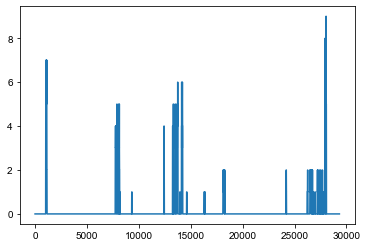

In [378]:
plt.plot(np.sum(list(transcriptID_2_vector.values()),axis=0))

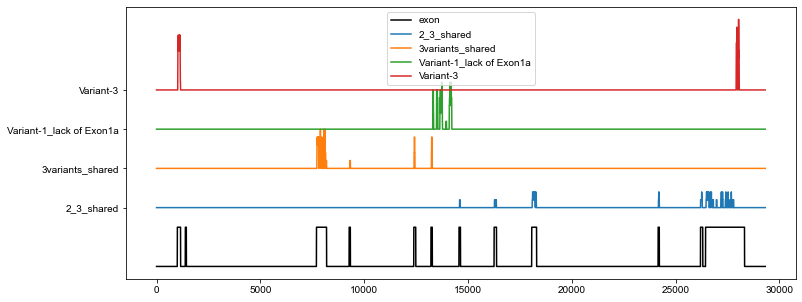

In [383]:
plt.figure(figsize=(12,5))
plt.plot(_feature_vector, 'black', label='exon')
_ticks, _tick_labels = [], []
for _i, (_t_id, _t_inds) in enumerate(transcriptID_2_inds.items()):
    #plt.bar(_t_inds+15, height=0.5, bottom=_i+1.5, width=30, label=_t_id)
    plt.plot(transcriptID_2_vector[_t_id]/5+_i+1.5, label=_t_id)
    _ticks.append(_i+1.5)
    _tick_labels.append(_t_id)
plt.yticks(_ticks, _tick_labels)
plt.legend()
plt.savefig(os.path.join(library_folder, 'probe_map_to_DNA_summary.png'))
plt.show()